In [1]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("yuriykatser/skoltech-anomaly-benchmark-skab")

print("Path to dataset files:", path)

d:\download\anaconda\envs\timeeval_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\liuyi\.cache\kagglehub\datasets\yuriykatser\skoltech-anomaly-benchmark-skab\versions\1


## Explore the data

### Structure and visulization

In this part, we organize the SKAB dataset by separating it into anomaly-free data and various types of anomalies, and then visualize an anomaly type

In [2]:
import os


# read all files and categorize them
other_anomaly_mapping = {
    '13.csv': 'Other - Rotor Imbalance (Sharply)',
    '14.csv': 'Other - Rotor Imbalance (Linear)',
    '15.csv': 'Other - Rotor Imbalance (Step)',
    '16.csv': 'Other - Rotor Imbalance (Dirac)',
    '17.csv': 'Other - Rotor Imbalance (Exponential)',
    '18.csv': 'Other - Water Increase (Slow)',
    '19.csv': 'Other - Water Increase (Sudden)',
    '20.csv': 'Other - Cavitation (Draining)',
    '21.csv': 'Other - Cavitation (Two-phase)',
    '22.csv': 'Other - Temperature Increase'
}

data_groups = {
    'Anomaly Free': [],
    'Valve 1': [],
    'Valve 2': []
}
for desc in other_anomaly_mapping.values():
    data_groups[desc] = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            
            if 'anomaly-free' in os.path.basename(root):
                data_groups['Anomaly Free'].append(file_path)
                
            elif 'valve1' in os.path.basename(root):
                data_groups['Valve 1'].append(file_path)
                
            elif 'valve2' in os.path.basename(root):
                data_groups['Valve 2'].append(file_path)
                
            elif 'other' in os.path.basename(root):
                if file in other_anomaly_mapping:
                    category = other_anomaly_mapping[file]
                    data_groups[category].append(file_path)
                else:
                    print(f"Warning: Unknown file in 'other': {file}")

print(f"{'Category':<40} | {'Count'}")
print("-" * 50)
for category, file_list in data_groups.items():
    file_list.sort() 
    print(f"{category:<40} | {len(file_list)}")

# data_groups['Valve 1']

Category                                 | Count
--------------------------------------------------
Anomaly Free                             | 1
Valve 1                                  | 16
Valve 2                                  | 4
Other - Rotor Imbalance (Sharply)        | 1
Other - Rotor Imbalance (Linear)         | 1
Other - Rotor Imbalance (Step)           | 1
Other - Rotor Imbalance (Dirac)          | 1
Other - Rotor Imbalance (Exponential)    | 1
Other - Water Increase (Slow)            | 1
Other - Water Increase (Sudden)          | 1
Other - Cavitation (Draining)            | 1
Other - Cavitation (Two-phase)           | 1
Other - Temperature Increase             | 1


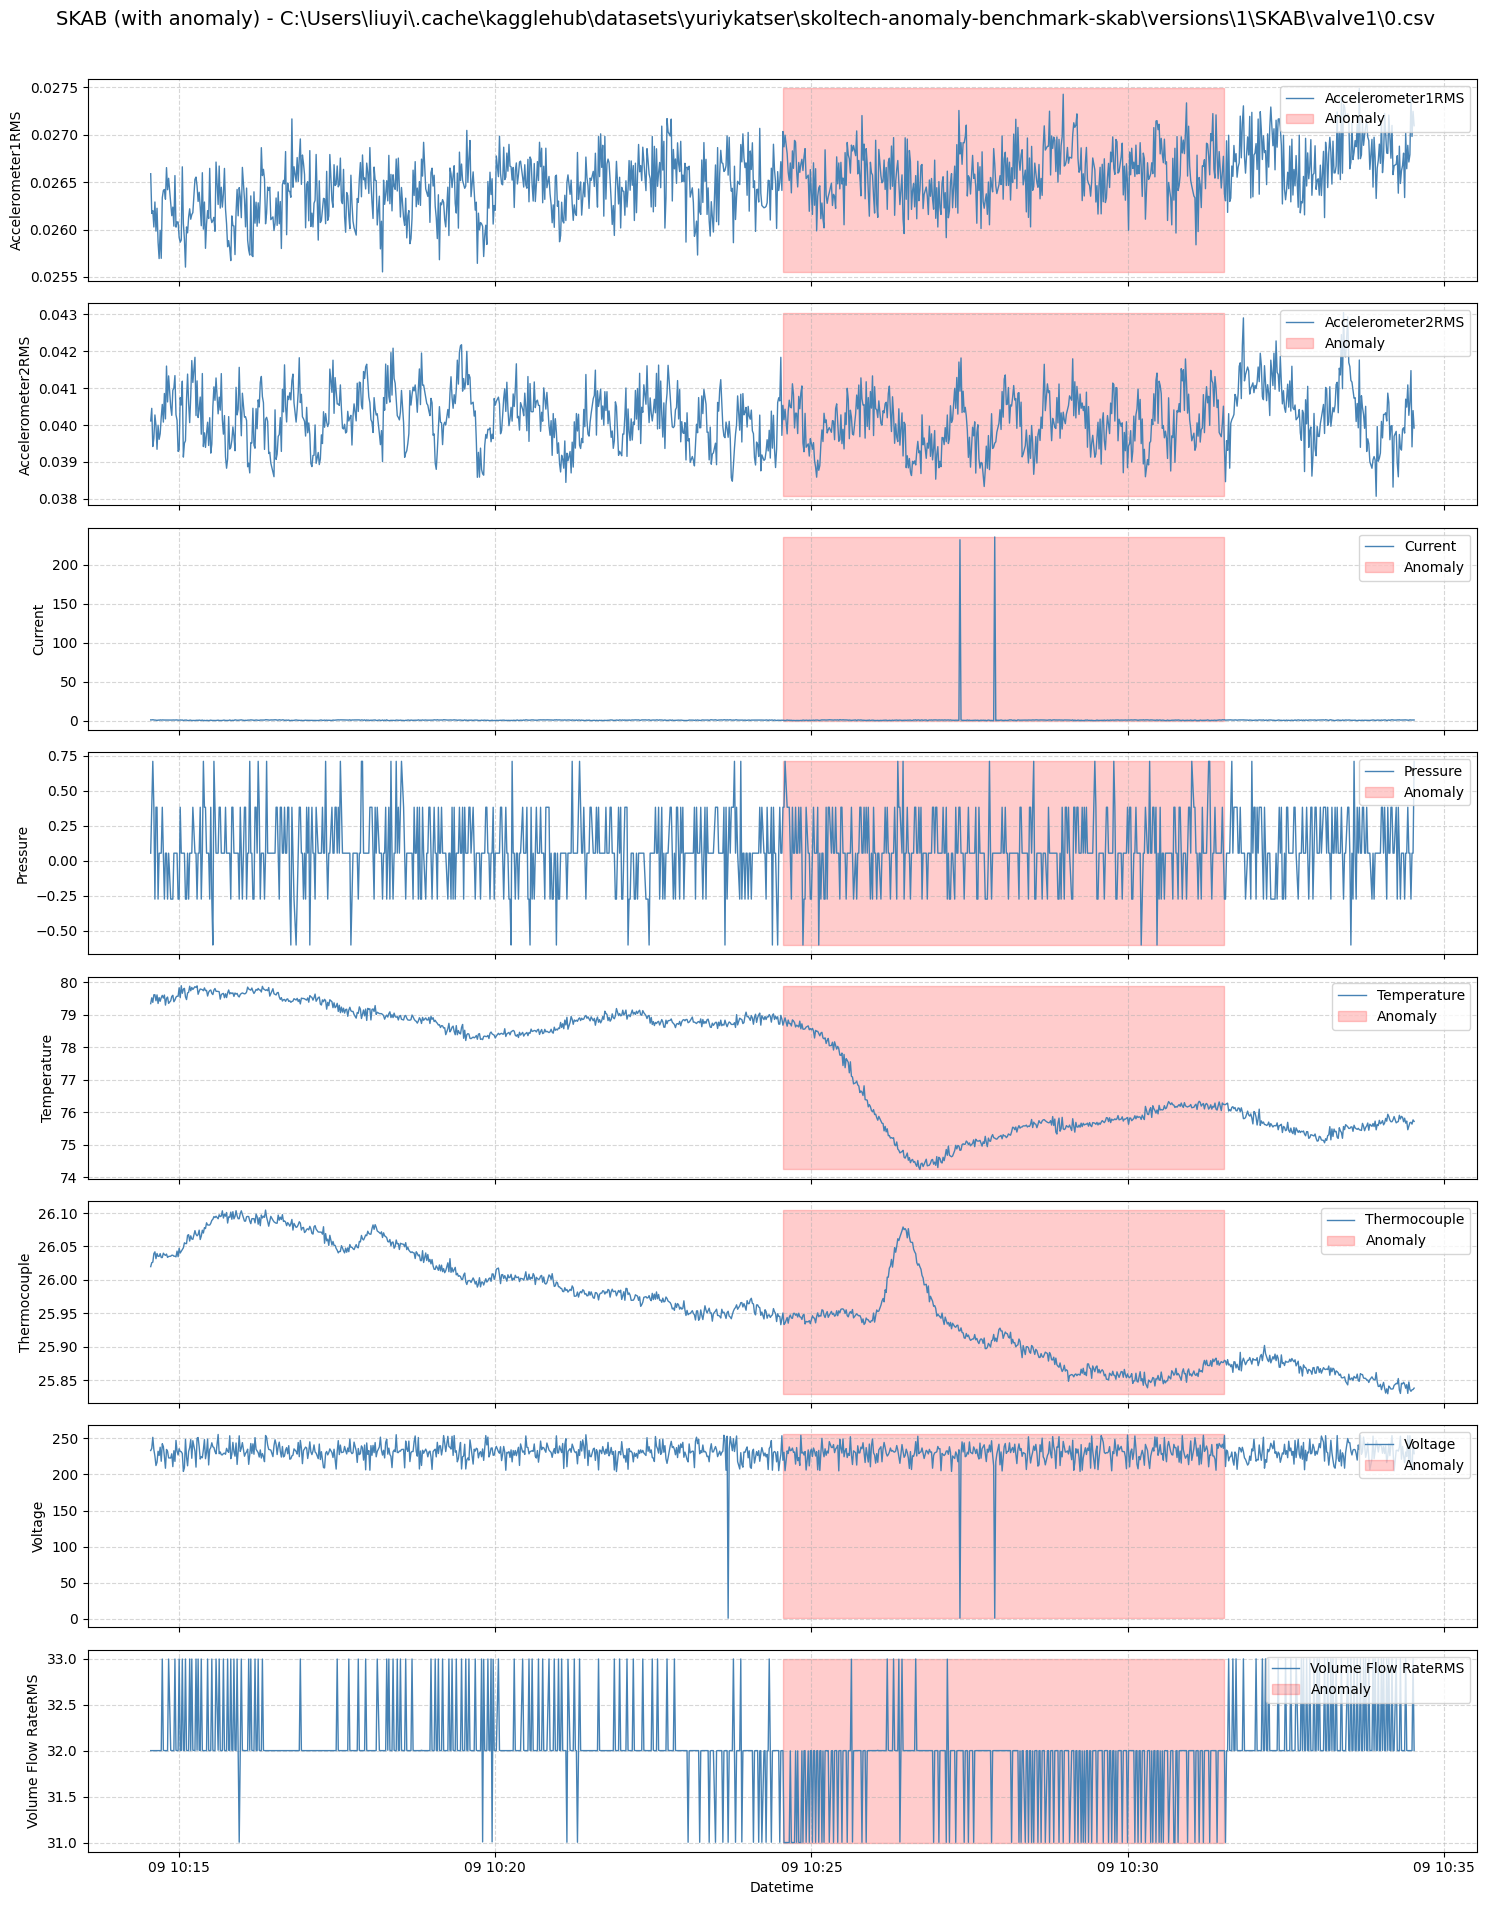

In [3]:
import matplotlib.pyplot as plt

def visualize_skab_data(data, title="SKAB Sensor Signals"):
    sensor_columns = [col for col in data.columns if col not in ['anomaly', 'changepoint']]

    fig, axes = plt.subplots(nrows=len(sensor_columns), ncols=1, 
                             figsize=(15, 2.5 * len(sensor_columns)), 
                             sharex=True, squeeze=False)

    for i, col in enumerate(sensor_columns):
        ax = axes[i, 0]
        ax.plot(data.index, data[col], label=col, color='steelblue', linewidth=1)

        if 'anomaly' in data.columns:
            ax.fill_between(data.index, data[col].min(), data[col].max(), 
                            where=data['anomaly'] == 1, color='red', alpha=0.2, label='Anomaly')
        
        ax.set_ylabel(col)
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.xlabel('Datetime')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

selected_file =data_groups['Valve 1'][0]

df = pd.read_csv(selected_file, sep=';', index_col='datetime', parse_dates=True)
if 'anomaly' in df.columns:
    df['anomaly'] = df['anomaly'].astype(int)

visualize_skab_data(df, title=f"SKAB (with anomaly) - {selected_file}")

### Feature Analysis

In this section, we extract initial statistics and properties for each feature (dimension). Based on these insights, we provide a preliminary assessment of suitable detection methods for various types of anomalies.

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller

def extract_features(df_file, target_sensors = ['Accelerometer1RMS','Accelerometer2RMS','Current','Pressure','Temperature','Thermocouple','Voltage','Volume Flow RateRMS']):
    """
    Extract statistical and time-series features from SKAB sensor data.
    Becuse the data is sampled at 1Hz, we focus on time-domain features.
    """
    features = {}
    
    for sensor in target_sensors:
        signal = df_file[sensor].values
        
        n = len(signal)
            
        # Basic Statistics
        features[f'{sensor}_Mean'] = np.mean(signal)
        features[f'{sensor}_Std'] = np.std(signal)  
        features[f'{sensor}_Max'] = np.max(signal)
        features[f'{sensor}_Kurtosis'] = stats.kurtosis(signal, fisher=False)
        
        # Autoregression & Complexity (Time Dependency)
        # Autocorrelation (Lag-1)
        features[f'{sensor}_Autocorr'] = np.corrcoef(signal[:-1], signal[1:])[0, 1]
        
        # Mobility (Hjorth Parameter)
        diff = np.diff(signal)
        std_signal = features[f'{sensor}_Std']
        if std_signal > 1e-9:
            features[f'{sensor}_Mobility'] = np.std(diff) / std_signal
        else:
            features[f'{sensor}_Mobility'] = 0


        # Trend & Stationarity
        x = np.arange(n)
        slope, intercept, r_value, p_value, std_err = linregress(x, signal)
        
        features[f'{sensor}_Slope'] = slope
        features[f'{sensor}_Trend_Strength'] = r_value**2  # 0~1, the closer to 1, the more obvious the linear deterioration
        
        # Stationarity - ADF Test
        # Detect whether the operating condition has sudden changes (Non-stationary).
        try:
            adf_result = adfuller(signal, maxlag=1, autolag=None)
            features[f'{sensor}_Is_Stationary'] = 1 if adf_result[1] < 0.05 else 0
        except:
            features[f'{sensor}_Is_Stationary'] = 0 

    return features


feature_list = []
print("Extracting features from all files...")

for category, file_paths in data_groups.items():
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, sep=';')
            numeric_df = df.select_dtypes(include=[np.number])
            
            if numeric_df.empty: continue

            feats = extract_features(numeric_df)
            feats['Category'] = category
            feature_list.append(feats)
            
        except Exception as e:
            print(f"Error: {e}")

df_features = pd.DataFrame(feature_list)
print("finished.")

df_features.head()

Extracting features from all files...
finished.


,Accelerometer1RMS_Mean,Accelerometer1RMS_Std,Accelerometer1RMS_Max,Accelerometer1RMS_Kurtosis,Accelerometer1RMS_Autocorr,Accelerometer1RMS_Mobility,Accelerometer1RMS_Slope,Accelerometer1RMS_Trend_Strength,Accelerometer1RMS_Is_Stationary,Accelerometer2RMS_Mean,...,Volume Flow RateRMS_Mean,Volume Flow RateRMS_Std,Volume Flow RateRMS_Max,Volume Flow RateRMS_Kurtosis,Volume Flow RateRMS_Autocorr,Volume Flow RateRMS_Mobility,Volume Flow RateRMS_Slope,Volume Flow RateRMS_Trend_Strength,Volume Flow RateRMS_Is_Stationary,Category
0,0.212277,0.004728,0.225967,3.155915,0.929232,0.376118,1.215376e-06,0.486626,1,0.268553,...,125.140908,1.671872,128.3530,2.980300,0.953804,0.303937,0.000485,0.620510,1,Anomaly Free
1,0.026521,0.000329,0.027489,2.749307,0.369018,1.123106,4.871007e-07,0.241384,1,0.040173,...,32.021791,0.458317,32.9986,4.716890,0.000764,1.414288,-0.000157,0.012881,1,Valve 1
2,0.026868,0.000312,0.027946,2.884260,0.029440,1.393617,1.151648e-07,0.014841,1,0.040045,...,31.566819,0.759689,33.0000,2.835052,0.558759,0.939683,-0.001057,0.211556,1,Valve 1
3,0.027755,0.000481,0.028911,2.481912,0.242216,1.231232,2.629722e-07,0.032721,1,0.041471,...,31.523800,1.156789,32.9808,2.508713,0.817646,0.604130,-0.001461,0.174572,1,Valve 1
4,0.027751,0.000399,0.029031,2.931577,0.347151,1.141105,-3.620578e-07,0.089318,1,0.040907,...,30.941518,2.214224,33.0000,2.305695,0.953633,0.304627,-0.002195,0.106617,0,Valve 1


In [5]:
import numpy as np
import pandas as pd

def remove_useless_sensors(df, threshold=1e-2):
    
    print(f"original feature: {df.shape[1]}")
    
    numeric_df = df.select_dtypes(include=[np.number])
    
    variances = numeric_df.var()
    
    all_columns = numeric_df.columns
    target_sensors = ['Temperature', 'Accelerometer2RMS', 'Volume Flow RateRMS', 'Voltage', 'Thermocouple', 'Current', 'Accelerometer1RMS', 'Pressure']
    
    useless_sensors = []
    
    # 4. 遍历每个传感器，检查其所有统计量的方差
    for sensor in target_sensors:
        sensor_cols = [col for col in all_columns if col.startswith(sensor + '_')]
        
        sensor_variances = variances[sensor_cols]
        
        if (sensor_variances <= threshold).all():
            useless_sensors.append(sensor)
            print(f"found useless sensor (to be removed): {sensor}")


    # 5. 执行移除
    cols_to_drop = []
    for sensor in useless_sensors:
        cols_to_drop.extend([col for col in df.columns if col.startswith(sensor + '_')])
    
    df_cleaned = df.drop(columns=cols_to_drop)
    
    print(f"number of removed sensors: {len(useless_sensors)}")
    print(f"number of removed feature columns: {len(cols_to_drop)}")
    print(f"number of features after filtering: {df_cleaned.shape[1]}")
    
    return df_cleaned, useless_sensors

df_final, dropped_sensors = remove_useless_sensors(df_features, threshold=0.01)

df_final.head()

original feature: 73
number of removed sensors: 0
number of removed feature columns: 0
number of features after filtering: 73


,Accelerometer1RMS_Mean,Accelerometer1RMS_Std,Accelerometer1RMS_Max,Accelerometer1RMS_Kurtosis,Accelerometer1RMS_Autocorr,Accelerometer1RMS_Mobility,Accelerometer1RMS_Slope,Accelerometer1RMS_Trend_Strength,Accelerometer1RMS_Is_Stationary,Accelerometer2RMS_Mean,...,Volume Flow RateRMS_Mean,Volume Flow RateRMS_Std,Volume Flow RateRMS_Max,Volume Flow RateRMS_Kurtosis,Volume Flow RateRMS_Autocorr,Volume Flow RateRMS_Mobility,Volume Flow RateRMS_Slope,Volume Flow RateRMS_Trend_Strength,Volume Flow RateRMS_Is_Stationary,Category
0,0.212277,0.004728,0.225967,3.155915,0.929232,0.376118,1.215376e-06,0.486626,1,0.268553,...,125.140908,1.671872,128.3530,2.980300,0.953804,0.303937,0.000485,0.620510,1,Anomaly Free
1,0.026521,0.000329,0.027489,2.749307,0.369018,1.123106,4.871007e-07,0.241384,1,0.040173,...,32.021791,0.458317,32.9986,4.716890,0.000764,1.414288,-0.000157,0.012881,1,Valve 1
2,0.026868,0.000312,0.027946,2.884260,0.029440,1.393617,1.151648e-07,0.014841,1,0.040045,...,31.566819,0.759689,33.0000,2.835052,0.558759,0.939683,-0.001057,0.211556,1,Valve 1
3,0.027755,0.000481,0.028911,2.481912,0.242216,1.231232,2.629722e-07,0.032721,1,0.041471,...,31.523800,1.156789,32.9808,2.508713,0.817646,0.604130,-0.001461,0.174572,1,Valve 1
4,0.027751,0.000399,0.029031,2.931577,0.347151,1.141105,-3.620578e-07,0.089318,1,0.040907,...,30.941518,2.214224,33.0000,2.305695,0.953633,0.304627,-0.002195,0.106617,0,Valve 1


## Test with 'timeeval'

### Format trasnformation

Canonical format:
```
timestamp,value,is_anomaly
0,12751.0,1
1,8767.0,0
2,7005.0,0
3,5257.0,0
4,4189.0,0
```

Idex file to form:

```
collection_name,dataset_name,train_path,test_path,dataset_type,datetime_index,split_at,train_type,train_is_normal,input_type,length,dimensions,contamination,num_anomalies,min_anomaly_length,median_anomaly_length,max_anomaly_length,mean,stddev,trend,stationarity,period_size
```


In [6]:
# process anomaly-free file to canonical format (train file)

# Note: in this dataset, sep=';'
anomaly_free_df = pd.read_csv(data_groups['Anomaly Free'][0], sep=';', parse_dates=['datetime'])


# 2. Reset index if 'datetime' is the index
if anomaly_free_df.index.name == 'datetime':
    anomaly_free_df.reset_index(inplace=True)

anomaly_free_df.rename(columns={'datetime': 'timestamp'}, inplace=True)
cols = ['timestamp'] + [c for c in anomaly_free_df.columns if c != 'timestamp']
anomaly_free_df = anomaly_free_df[cols]
anomaly_free_df['is_anomaly'] = 0

print("Transformed to conanical format：")
display(anomaly_free_df.head())

Transformed to conanical format：


,timestamp,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,is_anomaly
0,2020-02-08 13:30:47,0.206030,0.277924,1.81019,0.382638,90.1740,26.7760,228.208,121.664,0
1,2020-02-08 13:30:48,0.204366,0.275727,2.66317,-0.273216,90.2836,26.7760,227.245,122.000,0
2,2020-02-08 13:30:49,0.206103,0.278526,2.63758,0.382638,89.8666,26.7821,237.872,122.000,0
3,2020-02-08 13:30:51,0.204775,0.276948,2.32851,0.382638,90.2192,26.7773,230.422,121.338,0
4,2020-02-08 13:30:52,0.206052,0.278141,2.53422,0.382638,90.1449,26.7773,219.454,121.664,0


In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

def calculate_anomaly_stats(y_true):
    """计算异常片段的统计信息"""
    changes = np.diff(np.r_[0, y_true, 0])
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]
    lengths = ends - starts
    
    return {
        "num_anomalies": len(lengths),
        "min_anomaly_length": int(np.min(lengths)) if len(lengths) > 0 else 0,
        "median_anomaly_length": int(np.median(lengths)) if len(lengths) > 0 else 0,
        "max_anomaly_length": int(np.max(lengths)) if len(lengths) > 0 else 0,
    }

all_meta_rows = []
base_output_dir = Path("skabdata_v2")

print(f"{'Category':<35} | {'File':<15} | {'Status'}")
print("-" * 70)

for category, file_list in data_groups.items():
    
    if category == 'Anomaly Free':
        continue
        
    for src_path in file_list:
        try:
            df = pd.read_csv(src_path, sep=';', parse_dates=['datetime'])

            if 'changepoint' in df.columns:
                df.drop(columns=['changepoint'], inplace=True)

            df.rename(columns={'datetime': 'timestamp', 'anomaly': 'is_anomaly'}, inplace=True)
            df['is_anomaly'] = df['is_anomaly'].astype(int)

            feature_cols = [c for c in df.columns if c not in ['timestamp', 'is_anomaly']]
            df = df[['timestamp'] + feature_cols + ['is_anomaly']]

            src_path_obj = Path(src_path)
            parent_folder_name = src_path_obj.parent.name 
            file_stem = src_path_obj.stem  # 提取文件名（不含扩展名）
            output_dir = base_output_dir / parent_folder_name
            output_dir.mkdir(parents=True, exist_ok=True)
            
            dataset_unique_name = f"{parent_folder_name}_{file_stem}"
            output_filename = f"{dataset_unique_name}.test.csv"
            output_full_path = output_dir / output_filename
            

            df.to_csv(output_full_path, index=False)

            train_filename = 'skab_anomaly_free.train.csv'
            train_full_path = output_dir / train_filename
            
            if not train_full_path.exists():
                anomaly_free_df.to_csv(train_full_path, index=False)

            length = len(df)
            dimensions = len(feature_cols)
            contamination = df['is_anomaly'].mean()
            anomaly_stats = calculate_anomaly_stats(df['is_anomaly'].values)
            
            data_values = df[feature_cols].values.flatten()
            mean_val = float(np.mean(data_values))
            std_val = float(np.std(data_values))
            
            meta_row = {
                "collection_name": "skab",
                "dataset_name": dataset_unique_name, # 例如 valve1_0
                "train_path": f"{parent_folder_name}/{train_filename}",
                "test_path": f"{parent_folder_name}/{output_filename}",
                "dataset_type": "real",
                "datetime_index": True,
                "split_at": np.nan,
                "train_type": "semi-supervised",
                "train_is_normal": True,
                "input_type": "multivariate" if len(feature_cols) > 1 else "univariate",
                "length": length,
                "dimensions": dimensions,
                "contamination": contamination,
                "num_anomalies": anomaly_stats["num_anomalies"],
                "min_anomaly_length": anomaly_stats["min_anomaly_length"],
                "median_anomaly_length": anomaly_stats["median_anomaly_length"],
                "max_anomaly_length": anomaly_stats["max_anomaly_length"],
                "mean": mean_val,
                "stddev": std_val,
                "trend": "unknown",
                "stationarity": "unknown",
                "period_size": np.nan,
                # [新增] 具体的故障类别描述，非常有价值
                "anomaly_category": category 
            }
            
            all_meta_rows.append(meta_row)
            print(f"{category[:35]:<35} | {file_stem:<15} | Saved")

        except Exception as e:
            print(f"{category[:35]:<35} | {file_stem:<15} | Error: {e}")

index_file = base_output_dir / "datasets.csv"
meta_df = pd.DataFrame(all_meta_rows)

first_cols = ['collection_name', 'dataset_name', 'anomaly_category', 'contamination']
cols = first_cols + [c for c in meta_df.columns if c not in first_cols]
meta_df = meta_df[cols]

meta_df.to_csv(index_file, index=False)

print("\n" + "="*70)
print(f"Processing Complete.")
print(f"Index file saved to: {index_file}")
print(f"Total datasets processed: {len(meta_df)}")

try:
    display(meta_df.head())
except:
    print(meta_df.head())

Category                            | File            | Status
----------------------------------------------------------------------
Valve 1                             | 0               | Saved
Valve 1                             | 1               | Saved
Valve 1                             | 10              | Saved
Valve 1                             | 11              | Saved
Valve 1                             | 12              | Saved
Valve 1                             | 13              | Saved
Valve 1                             | 14              | Saved
Valve 1                             | 15              | Saved
Valve 1                             | 2               | Saved
Valve 1                             | 3               | Saved
Valve 1                             | 4               | Saved
Valve 1                             | 5               | Saved
Valve 1                             | 6               | Saved
Valve 1                             | 7               | Save

,collection_name,dataset_name,anomaly_category,contamination,train_path,test_path,dataset_type,datetime_index,split_at,train_type,...,dimensions,num_anomalies,min_anomaly_length,median_anomaly_length,max_anomaly_length,mean,stddev,trend,stationarity,period_size
0,skab,valve1_0,Valve 1,0.349303,valve1/skab_anomaly_free.train.csv,valve1/valve1_0.test.csv,real,True,NaN,semi-supervised,...,8,1,401,401,401,45.912549,74.358040,unknown,unknown,NaN
1,skab,valve1_1,Valve 1,0.351092,valve1/skab_anomaly_free.train.csv,valve1/valve1_1.test.csv,real,True,NaN,semi-supervised,...,8,1,402,402,402,45.444280,74.366199,unknown,unknown,NaN
2,skab,valve1_10,Valve 1,0.349913,valve1/skab_anomaly_free.train.csv,valve1/valve1_10.test.csv,real,True,NaN,semi-supervised,...,8,1,401,401,401,44.535243,73.862622,unknown,unknown,NaN
3,skab,valve1_11,Valve 1,0.349693,valve1/skab_anomaly_free.train.csv,valve1/valve1_11.test.csv,real,True,NaN,semi-supervised,...,8,1,399,399,399,44.514465,73.980867,unknown,unknown,NaN
4,skab,valve1_12,Valve 1,0.350000,valve1/skab_anomaly_free.train.csv,valve1/valve1_12.test.csv,real,True,NaN,semi-supervised,...,8,1,399,399,399,44.448605,73.824378,unknown,unknown,NaN


In [8]:
from pathlib import Path
from typing import Dict, Any

import numpy as np

from timeeval import TimeEval, DatasetManager, Algorithm, TrainingType, InputDimensionality
from timeeval.adapters import FunctionAdapter
from timeeval.algorithms import (
    lstm_ad,        # 1. 深度预测
    encdec_ad,      # 2. 深度重构 (确定性)
    omnianomaly,    # 3. 深度重构 (概率/VAE)
    fast_mcd,       # 4. 统计学基线
    iforest,        # 5. 经典 ML 基线 (新增)
    mtad_gat        # 6. 图神经网络 SOTA (新增)
)

from timeeval.params import FixedParameters

# Load dataset metadata
dm = DatasetManager(Path("skabdata_v2"), create_if_missing=False)

# Select datasets and algorithms
datasets = dm.select()
datasets = datasets[-1:]

algorithms = [
    # === A. 经典与统计基线 ===
    
    # 1. Fast-MCD (统计学)
    # 强项: 极快，利用马氏距离检测偏离正态分布的异常
    fast_mcd(params=FixedParameters({
        "support_fraction": 0.9
    })),

    # 2. Isolation Forest (经典 ML)
    # 强项: 工业界标准，不依赖梯度下降，不仅快而且对多维数据非常鲁棒
    iforest(params=FixedParameters({
        "n_trees": 100,      # 树的数量
        "max_samples": 256   # 每棵树的样本采样数
    })),

    # === B. 深度学习 - 预测与重构 ===

    # 3. LSTM-AD (预测类)
    # 强项: 学习时间序列的时序模式，无法预测即为异常
    lstm_ad(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # 4. EncDec-AD (重构类 - 确定性)
    # 强项: LSTM Autoencoder，压缩再解压，异常点无法被准确还原
    encdec_ad(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # 5. OmniAnomaly (重构类 - 概率性)
    # 强项: VAE (变分自编码器)，学习数据的概率分布，捕捉复杂相关性
    omnianomaly(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # === C. 深度学习 - 空间/图关系 ===

    # 6. MTAD-GAT (图注意力网络)
    # 强项: 显式建模变量(传感器)之间的关系图，特别适合物理系统
    mtad_gat(params=FixedParameters({
        "epochs": 10,
        "window_size": 30,
    }))
]

# --- 3. 运行评测 ---
print(f"开始评测 {len(algorithms)} 种代表性算法...")

timeeval = TimeEval(dm, datasets, algorithms, force_training_type_match=False, force_dimensionality_match=False)

# execute evaluation
timeeval.run()
# retrieve results
print(timeeval.get_results())


开始评测 6 种代表性算法...
Running PREPARE phase
Running EVALUATION phase


Evaluating: 100%|██████████| 6/6 [07:57<00:00, 79.52s/it] 

Running FINALIZE phase
FINALIZE phase done.
          Stored results at D:\学习资料\大学\MVA\timeseries\time_seires_projet\results\2026_01_03_23_06_30\results.csv.
          Overall runtime of this TimeEval run: 652.2874794006348 seconds
        
                                                ROC_AUC_mean  \
algorithm                  collection dataset                  
EncDec-AD                  skab       valve2_3      0.816291   
Fast-MCD                   skab       valve2_3      0.764658   
Isolation Forest (iForest) skab       valve2_3      0.557207   
LSTM-AD                    skab       valve2_3      0.704392   
MTAD-GAT                   skab       valve2_3      0.550814   
OmniAnomaly                skab       valve2_3      0.848979   

                                                train_main_time_mean  \
algorithm                  collection dataset                          
EncDec-AD                  skab       valve2_3             45.478745   
Fast-MCD                   ska

C:\Users\liuyi\AppData\Local\Temp\ipykernel_30072\2864108566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='algorithm', y='ROC_AUC_mean', data=sorted_df, ax=axes[0], palette='viridis')


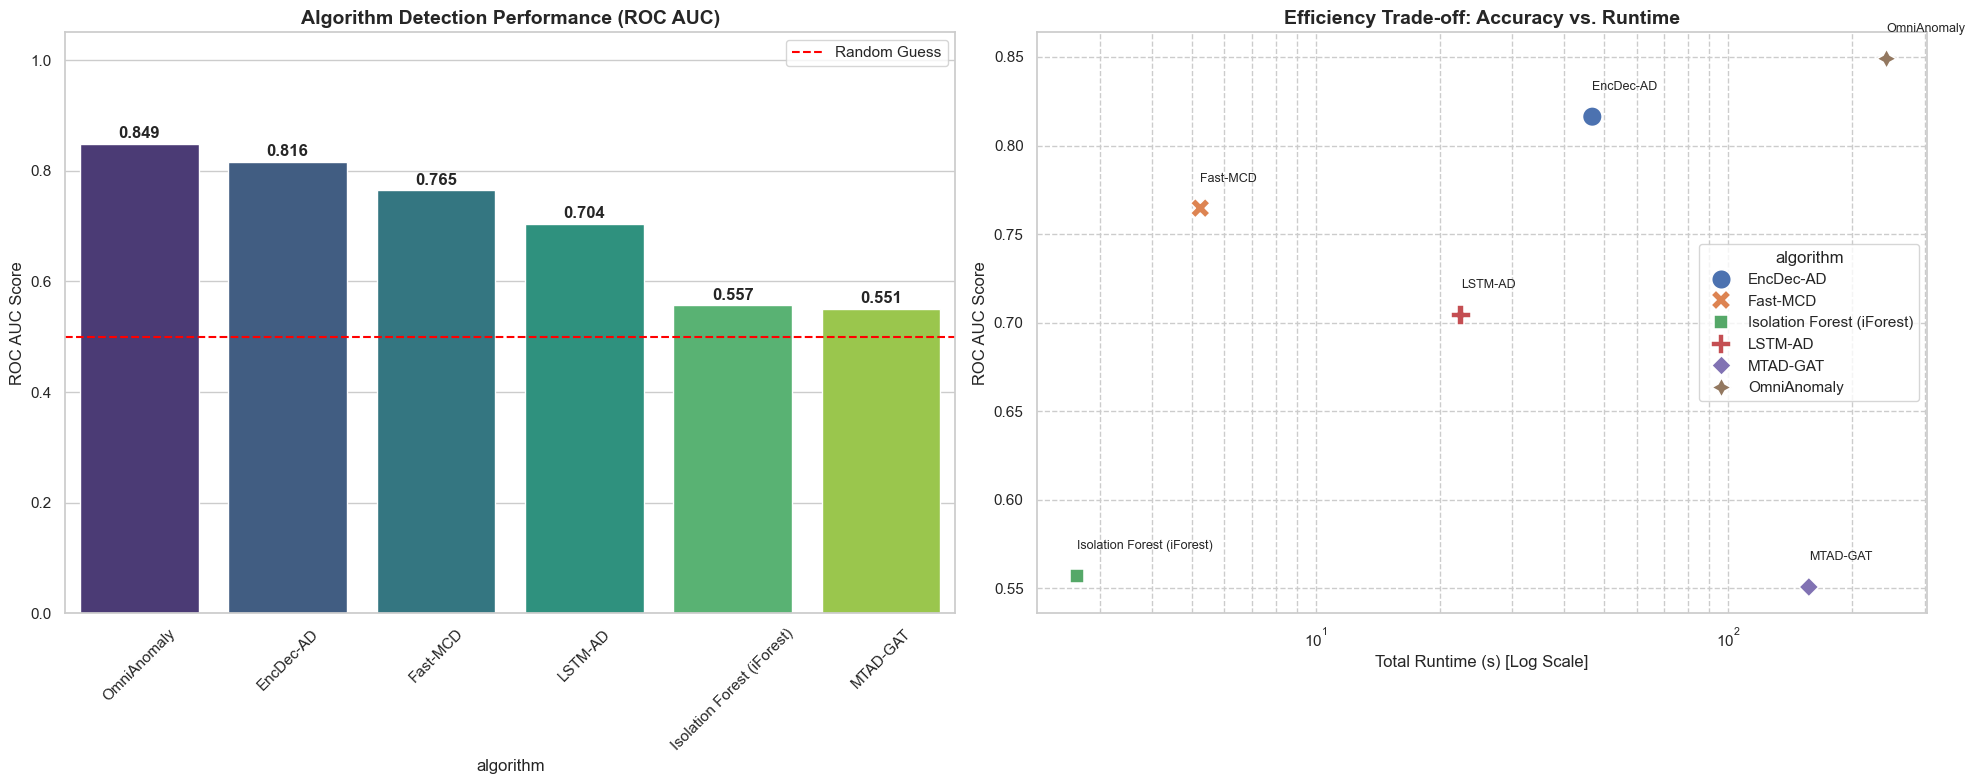

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df = timeeval.get_results().reset_index()

target_cols = ['algorithm', 'ROC_AUC_mean', 'train_main_time_mean', 'execute_main_time_mean']
available_cols = [c for c in target_cols if c in df.columns]
plot_df = df[available_cols].copy()

if 'train_main_time_mean' in plot_df.columns:
    plot_df['train_main_time_mean'] = plot_df['train_main_time_mean'].fillna(0)
if 'execute_main_time_mean' in plot_df.columns:
    plot_df['execute_main_time_mean'] = plot_df['execute_main_time_mean'].fillna(0)

plot_df['total_time'] = plot_df['train_main_time_mean'] + plot_df['execute_main_time_mean']

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- 图表 1: 准确率排行榜 (ROC_AUC) ---
sorted_df = plot_df.sort_values(by='ROC_AUC_mean', ascending=False)

sns.barplot(x='algorithm', y='ROC_AUC_mean', data=sorted_df, ax=axes[0], palette='viridis')
axes[0].set_title('Algorithm Detection Performance (ROC AUC)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('ROC AUC Score')
axes[0].set_ylim(0, 1.05)
axes[0].axhline(0.5, color='red', linestyle='--', label='Random Guess')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45) 

for i, v in enumerate(sorted_df['ROC_AUC_mean']):
    axes[0].text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')

# --- 图表 2: 性价比分析 ---
sns.scatterplot(data=plot_df, x='total_time', y='ROC_AUC_mean', 
                hue='algorithm', style='algorithm', s=200, ax=axes[1], palette='deep')

axes[1].set_title('Efficiency Trade-off: Accuracy vs. Runtime', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Runtime (s) [Log Scale]')
axes[1].set_ylabel('ROC AUC Score')
axes[1].set_xscale('log') 
axes[1].grid(True, which="both", ls="--")

# 添加标签
for i in range(plot_df.shape[0]):
    row = plot_df.iloc[i]
    # 稍微错开标签位置
    axes[1].text(row['total_time'], row['ROC_AUC_mean']+0.015, 
                 row['algorithm'], fontsize=9, ha='left')

plt.tight_layout()
plt.show()

In [ ]:
# Run TimeEval evaluation on all SKAB dataset with selected algorithms, it will take a long time

from pathlib import Path
from typing import Dict, Any

import numpy as np

from timeeval import TimeEval, DatasetManager, Algorithm, TrainingType, InputDimensionality
from timeeval.adapters import FunctionAdapter
from timeeval.algorithms import (
    lstm_ad,        # 1. 深度预测
    encdec_ad,      # 2. 深度重构 (确定性)
    omnianomaly,    # 3. 深度重构 (概率/VAE)
    fast_mcd,       # 4. 统计学基线
    iforest,        # 5. 经典 ML 基线 (新增)
    mtad_gat        # 6. 图神经网络 SOTA (新增)
)

from timeeval.params import FixedParameters

# Load dataset metadata
dm = DatasetManager(Path("skabdata_v2"), create_if_missing=False)

# Select datasets and algorithms
datasets = dm.select()

algorithms = [
    # === A. 经典与统计基线 ===
    
    # 1. Fast-MCD (统计学)
    # 强项: 极快，利用马氏距离检测偏离正态分布的异常
    fast_mcd(params=FixedParameters({
        "support_fraction": 0.9
    })),

    # 2. Isolation Forest (经典 ML)
    # 强项: 工业界标准，不依赖梯度下降，不仅快而且对多维数据非常鲁棒
    iforest(params=FixedParameters({
        "n_trees": 100,      # 树的数量
        "max_samples": 256   # 每棵树的样本采样数
    })),

    # === B. 深度学习 - 预测与重构 ===

    # 3. LSTM-AD (预测类)
    # 强项: 学习时间序列的时序模式，无法预测即为异常
    lstm_ad(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # 4. EncDec-AD (重构类 - 确定性)
    # 强项: LSTM Autoencoder，压缩再解压，异常点无法被准确还原
    encdec_ad(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # 5. OmniAnomaly (重构类 - 概率性)
    # 强项: VAE (变分自编码器)，学习数据的概率分布，捕捉复杂相关性
    omnianomaly(params=FixedParameters({
        "epochs": 10,
        "window_size": 30
    })),

    # === C. 深度学习 - 空间/图关系 ===

    # 6. MTAD-GAT (图注意力网络)
    # 强项: 显式建模变量(传感器)之间的关系图，特别适合物理系统
    mtad_gat(params=FixedParameters({
        "epochs": 10,
        "window_size": 30,
    }))
]

# --- 3. 运行评测 ---
print(f"开始评测 {len(algorithms)} 种代表性算法...")

timeeval = TimeEval(dm, datasets, algorithms, force_training_type_match=False, force_dimensionality_match=False)

# execute evaluation
timeeval.run()
# retrieve results
print(timeeval.get_results())

开始评测 6 种代表性算法...
Running PREPARE phase
Running EVALUATION phase


Evaluating:   6%|▌         | 10/180 [00:44<12:45,  4.50s/it]

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_df = timeeval.get_results()

meta_df = dm.df()

meta_subset = meta_df[['dataset_name', 'anomaly_category']].copy()

full_df = pd.merge(
    results_df, 
    meta_subset, 
    left_on='dataset', 
    right_on='dataset_name', 
    how='left'
)


category_perf = full_df.groupby(['anomaly_category', 'algorithm'])['ROC_AUC_mean'].mean().reset_index()

best_performers = category_perf.loc[category_perf.groupby('anomaly_category')['ROC_AUC_mean'].idxmax()]

best_performers = best_performers.sort_values(by='ROC_AUC_mean', ascending=False)

print("\n" + "="*50)
print("🏆 各异常种类表现最好的算法 (Best per Category)")
print("="*50)
print(best_performers.to_string(index=False))


pivot_table = category_perf.pivot(index="anomaly_category", columns="algorithm", values="ROC_AUC_mean")

plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

ax = sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".3f", 
    cmap="viridis", 
    linewidths=.5, 
    cbar_kws={'label': 'Mean ROC_AUC'}
)

plt.title('Algorithm Performance by Anomaly Category (SKAB)', fontsize=15, fontweight='bold')
plt.ylabel('Anomaly Category', fontsize=12)
plt.xlabel('Algorithm', fontsize=12)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(
    data=best_performers, 
    x='ROC_AUC_mean', 
    y='anomaly_category', 
    hue='algorithm', 
    dodge=False, 
    palette='deep'
)
plt.title('Winner Algorithms per Category', fontsize=15, fontweight='bold')
plt.xlabel('Best ROC AUC Score')
plt.xlim(0, 1.05)
plt.legend(title='Winning Algorithm', loc='lower right')
plt.tight_layout()
plt.show()